In [1]:
import ccxt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import matplotlib.pyplot as plt

import json
import time
import os
import sys

In [2]:
src_path = '../src/'
sys.path.append(os.path.abspath(src_path))
from func_get import *
from func_signal import *
from func_backtest import *

In [3]:
start_ts = time.time()

In [4]:
interval_dict = {
    '1m': 1,
    '5m': 5,
    '15m': 15,
    '30m': 30,
    '1h': 60,
    '2h': 120,
    '4h': 240,
    '1d': 1440
}

In [5]:
with open('../../../_keys/ftx/ftx_read_keys.json') as keys_file:
    keys_dict = json.load(keys_file)
    
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

### Config

In [6]:
project_name = 'messi'

In [7]:
start_date = dt.datetime(2022, 1, 1)
start_hour = 1
end_date = dt.datetime.today() - dt.timedelta(days=1)
reinvest_profit_flag = True

In [8]:
config_params = {
    'safety_ohlcv_range': 1000,
    'action_timeframe': '2h',
    'target_side': ['buy', 'sell'],
    'base': {
        'symbol': ['ETH-PERP'],
        'open': {
            '2h': {
                'tma': {
                    'check': [check_signal_side_change],
                    'look_back': 1,
                    'windows': 50,
                    'revert': False
                }
            }
        },
        'close': {
            '2h': {
                'tma': {
                    'check': [check_signal_side],
                    'look_back': 1,
                    'windows': 50,
                    'revert': False
                }
            }
        }
    },
    'lead': {
        'symbol': [],
        'open': {
        },
        'close': {
        }
    },
    'tp': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None,
    },
    'sl': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None
    },
    'action_percent': 100,
    'leverage': 1,
    'taker_fee_percent': 0.07
}

### Get data

In [9]:
ohlcv_df_dict = get_data(exchange, start_date, end_date, start_hour, interval_dict, config_params)

base: timeframe 1/1 symbol 1/1 date 1/263
base: timeframe 1/1 symbol 1/1 date 2/263
base: timeframe 1/1 symbol 1/1 date 3/263
base: timeframe 1/1 symbol 1/1 date 4/263
base: timeframe 1/1 symbol 1/1 date 5/263
base: timeframe 1/1 symbol 1/1 date 6/263
base: timeframe 1/1 symbol 1/1 date 7/263
base: timeframe 1/1 symbol 1/1 date 8/263
base: timeframe 1/1 symbol 1/1 date 9/263
base: timeframe 1/1 symbol 1/1 date 10/263
base: timeframe 1/1 symbol 1/1 date 11/263
base: timeframe 1/1 symbol 1/1 date 12/263
base: timeframe 1/1 symbol 1/1 date 13/263
base: timeframe 1/1 symbol 1/1 date 14/263
base: timeframe 1/1 symbol 1/1 date 15/263
base: timeframe 1/1 symbol 1/1 date 16/263
base: timeframe 1/1 symbol 1/1 date 17/263
base: timeframe 1/1 symbol 1/1 date 18/263
base: timeframe 1/1 symbol 1/1 date 19/263
base: timeframe 1/1 symbol 1/1 date 20/263
base: timeframe 1/1 symbol 1/1 date 21/263
base: timeframe 1/1 symbol 1/1 date 22/263
base: timeframe 1/1 symbol 1/1 date 23/263
base: timeframe 1/1 

base: timeframe 1/1 symbol 1/1 date 190/263
base: timeframe 1/1 symbol 1/1 date 191/263
base: timeframe 1/1 symbol 1/1 date 192/263
base: timeframe 1/1 symbol 1/1 date 193/263
base: timeframe 1/1 symbol 1/1 date 194/263
base: timeframe 1/1 symbol 1/1 date 195/263
base: timeframe 1/1 symbol 1/1 date 196/263
base: timeframe 1/1 symbol 1/1 date 197/263
base: timeframe 1/1 symbol 1/1 date 198/263
base: timeframe 1/1 symbol 1/1 date 199/263
base: timeframe 1/1 symbol 1/1 date 200/263
base: timeframe 1/1 symbol 1/1 date 201/263
base: timeframe 1/1 symbol 1/1 date 202/263
base: timeframe 1/1 symbol 1/1 date 203/263
base: timeframe 1/1 symbol 1/1 date 204/263
base: timeframe 1/1 symbol 1/1 date 205/263
base: timeframe 1/1 symbol 1/1 date 206/263
base: timeframe 1/1 symbol 1/1 date 207/263
base: timeframe 1/1 symbol 1/1 date 208/263
base: timeframe 1/1 symbol 1/1 date 209/263
base: timeframe 1/1 symbol 1/1 date 210/263
base: timeframe 1/1 symbol 1/1 date 211/263
base: timeframe 1/1 symbol 1/1 d

### Add signal

In [10]:
ohlcv_df_dict = add_signal(start_date, ohlcv_df_dict, interval_dict, config_params)

base add tma to ETH-PERP 2h


### Back test

In [11]:
action_time_list = gen_action_time_list(config_params, ohlcv_df_dict)
max_open_timeframe = get_max_open_timeframe(config_params, interval_dict)

In [12]:
budget = 100

transaction_dict = {
    'symbol': [],
    'side': [],
    'amount': [],
    'open_time': [],
    'open_price': [],
    'close_time': [],
    'close_price': [],
    'value': [],
    'notional': [],
    'profit': [],
    'profit_percent': []
}

position_dict = {}

if reinvest_profit_flag == True:
    budget_dict = {
        'time': [],
        'budget': []
    }
    
max_drawdown = 0

In [13]:
if reinvest_profit_flag == True:
    min_budget = budget

time_count = 0

for signal_time in action_time_list:
    action_time = signal_time + dt.timedelta(minutes=interval_dict[config_params['action_timeframe']])
    
    time_count += 1
    print(f"Time {action_time}: progress {time_count}/{len(action_time_list)}")

    '''
    Close positions
    '''
    for symbol in [x for x in position_dict.keys()]:
        print(f"  {symbol}")
        budget, max_drawdown, position_dict, transaction_dict = close_position(symbol, signal_time, max_drawdown, config_params, budget, reinvest_profit_flag, ohlcv_df_dict, position_dict, transaction_dict, interval_dict)

    '''
    Open positions
    '''
    max_position = int(1 / (config_params['action_percent'] / 100))

    for symbol in [x for x in config_params['base']['symbol'] if x not in position_dict.keys()][:max_position]:
        print(f"  {symbol}")
        position_dict = open_position(symbol, signal_time, max_open_timeframe, config_params, budget, ohlcv_df_dict, position_dict, interval_dict)    
    
    '''
    Update budget
    '''
    if reinvest_profit_flag == True:
        budget_dict['time'].append(signal_time)
        budget_dict['budget'].append(budget)

        if budget < min_budget:
            min_budget = budget

    if budget <= 0:
        print(f"Out of money at {action_time}")
        break
        
'''
Clear final position
'''
opened_symbol = list(position_dict.keys())

for symbol in opened_symbol:
    print(f" Clear {symbol} position")
    
    side = position_dict[symbol]['side']
    ohlcv_df = ohlcv_df_dict['base'][config_params['action_timeframe']][symbol]
    current_ohlcv_df = ohlcv_df[ohlcv_df['time'] == signal_time].reset_index(drop=True)
    close_price = current_ohlcv_df.loc[0, 'close']
    close_percent = 100
    
    budget, position_dict, transaction_dict = update_close_position(symbol, side, close_price, close_percent, signal_time, config_params, budget, reinvest_profit_flag, position_dict, transaction_dict, interval_dict)

Time 2022-01-01 03:00:00: progress 1/1152
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 05:00:00: progress 2/1152
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 07:00:00: progress 3/1152
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 09:00:00: progress 4/1152
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 11:00:00: progress 5/1152
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 13:00:00: progress 6/1152
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 15:00:00: progress 7/1152
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2022-01-01 17:00:00: progress 8/1152
  ETH-PERP
     base ETH-PERP check_signal_side_

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-22 05:00:00: progress 254/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-22 07:00:00: progress 255/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-22 09:00:00: progress 256/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-22 11:00:00: progress 257/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-22 13:00:00: progress 258/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-22 15:00:00: progress 259/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-22 17:00:00: progress 260/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-22 19:00:00: progress 261/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma

     Not close
Time 2022-02-10 09:00:00: progress 484/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 11:00:00: progress 485/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 13:00:00: progress 486/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 15:00:00: progress 487/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 17:00:00: progress 488/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 19:00:00: progress 489/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 21:00:00: progress 490/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-10 23:00:00: progress 491/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-02-11 01:00:00: progres

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-02 21:00:00: progress 730/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-02 23:00:00: progress 731/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-03 01:00:00: progress 732/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-03 03:00:00: progress 733/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-03 05:00:00: progress 734/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-03 07:00:00: progress 735/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-03 09:00:00: progress 736/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-03 11:00:00: progress 737/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy

     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 3010.0
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.03879977150788239
     price: 3010.0
     tp: inf
     sl: 0
Time 2022-03-22 13:00:00: progress 966/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-22 15:00:00: progress 967/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-22 17:00:00: progress 968/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-22 19:00:00: progress 969/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-22 21:00:00: progress 970/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-22 23:00:00: progress 971/1152
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-23 01:00:00: progress 972/1152
  ETH-PERP
     base 

In [14]:
end_ts = time.time()
time_process = end_ts - start_ts
print(f"Time process: {round(time_process / 60, 2)} minutes")

Time process: 0.92 minutes


### Result

In [15]:
transaction_df = pd.DataFrame(transaction_dict)
transaction_df.to_csv(f'transactions/{project_name}.csv', index=False)
transaction_df

,symbol,side,amount,open_time,open_price,close_time,close_price,value,notional,profit,profit_percent
0,ETH-PERP,buy,0.026592,2022-01-02 01:00:00,3760.6,2022-01-04 03:00:00,3738.5,100.000000,100.000000,-0.727261,-0.726752
1,ETH-PERP,sell,0.026554,2022-01-04 03:00:00,3738.5,2022-01-04 07:00:00,3765.0,99.272739,99.272739,-0.843160,-0.849932
2,ETH-PERP,buy,0.026143,2022-01-04 07:00:00,3765.0,2022-01-04 09:00:00,3732.2,98.429579,98.429579,-0.994702,-1.009865
3,ETH-PERP,sell,0.026107,2022-01-04 09:00:00,3732.2,2022-01-04 15:00:00,3763.8,97.434878,97.434878,-0.961953,-0.987970
4,ETH-PERP,buy,0.025632,2022-01-04 15:00:00,3763.8,2022-01-06 01:00:00,3773.1,96.472924,96.472924,0.103147,0.106843
5,ETH-PERP,sell,0.025596,2022-01-06 01:00:00,3773.1,2022-01-11 23:00:00,3133.0,96.576071,96.576071,16.260229,16.848499
6,ETH-PERP,buy,0.036015,2022-01-11 23:00:00,3133.0,2022-01-14 19:00:00,3202.6,112.836299,112.836299,2.346947,2.078503
7,ETH-PERP,sell,0.035966,2022-01-14 19:00:00,3202.6,2022-01-14 23:00:00,3278.8,115.183247,115.183247,-2.903749,-2.522748
8,ETH-PERP,buy,0.034244,2022-01-14 23:00:00,3278.8,2022-01-17 11:00:00,3259.0,112.279498,112.279498,-0.834750,-0.742937
9,ETH-PERP,sell,0.034196,2022-01-17 11:00:00,3259.0,2022-01-20 21:00:00,3183.7,111.444748,111.444748,2.420738,2.173664


In [16]:
if reinvest_profit_flag == True:
    print(f"Final budget: {round(budget, 2)}")
else:
    print("Not reinvest profit")

Final budget: 133.85


In [17]:
if reinvest_profit_flag == True:
    return_percent = (budget_dict['budget'][-1] - budget_dict['budget'][0]) / budget_dict['budget'][0] * 100
    print(f"Return: {round(return_percent, 2)}%")
else:
    print("Not reinvest profit")

Return: 24.75%


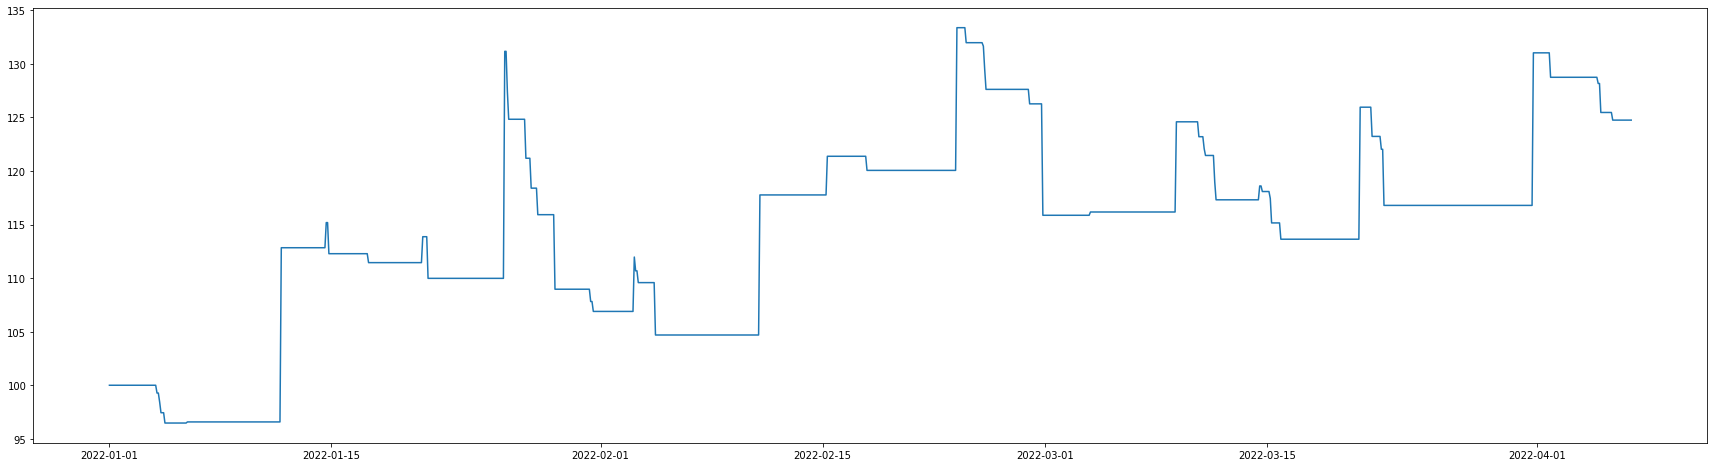

In [18]:
if reinvest_profit_flag == True:
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(budget_dict['time'], budget_dict['budget'])
else:
    print("Not reinvest profit")

In [19]:
if reinvest_profit_flag == True:
    print(f"Max drawdown: {round(max_drawdown * 100, 2)}%")

Max drawdown: 8.09%


In [20]:
win_rate = len(transaction_df[transaction_df['profit'] > 0]) / len(transaction_df)
print(f"Win rate: {round(win_rate * 100, 2)}%")

Win rate: 26.79%


In [21]:
for symbol in transaction_df['symbol'].unique():
    symbol_df = transaction_df[transaction_df['symbol'] == symbol]
    win_rate = len(symbol_df[symbol_df['profit'] > 0]) / len(symbol_df)
    print(f"{symbol} win rate: {round(win_rate * 100, 2)}%")

ETH-PERP win rate: 26.79%


In [22]:
print(f"Distribution")
print(pd.DataFrame(transaction_df['profit_percent'].describe()))

Distribution
       profit_percent
count       56.000000
mean         0.652555
std          5.326063
min         -8.243055
25%         -1.964617
50%         -0.990450
75%          0.146176
max         19.280460


In [23]:
for symbol in transaction_df['symbol'].unique():
    temp_return = transaction_df[transaction_df['symbol'] == symbol]['profit_percent']
    
    print(f"Distribution {symbol}:")
    print(pd.DataFrame(temp_return.describe()))
    print("\n")

Distribution ETH-PERP:
       profit_percent
count       56.000000
mean         0.652555
std          5.326063
min         -8.243055
25%         -1.964617
50%         -0.990450
75%          0.146176
max         19.280460




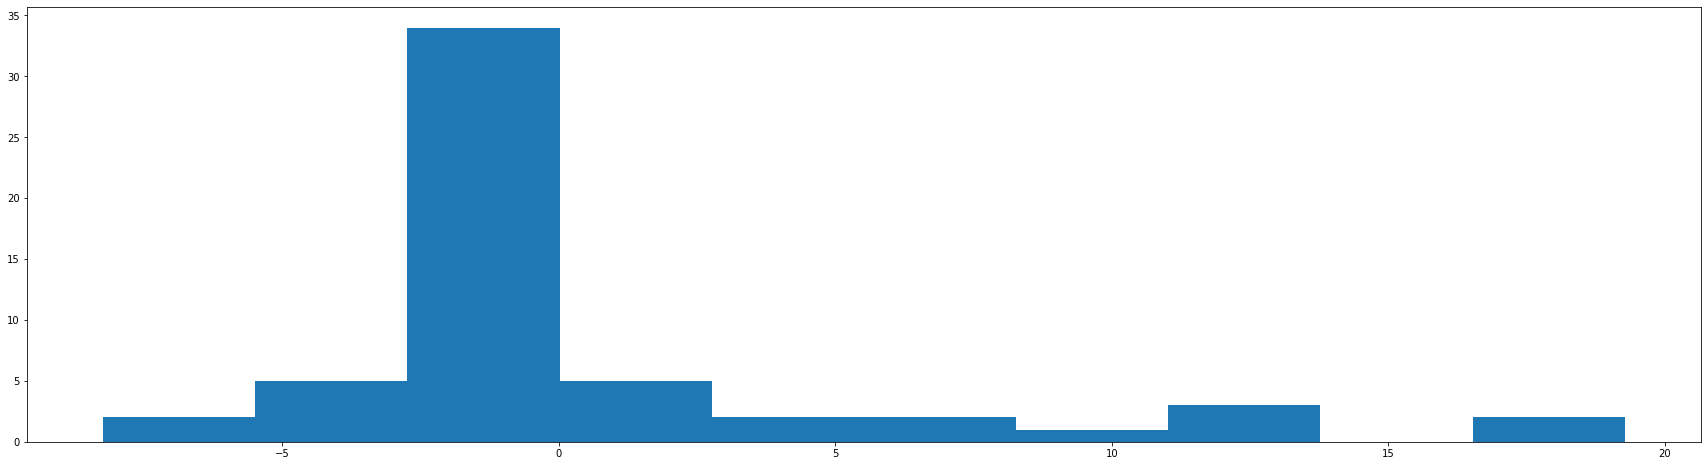

In [24]:
fig, ax = plt.subplots(figsize=(30, 8))
_ = ax.hist(transaction_df['profit_percent'], bins=10)